In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.label = label
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp')

        def _backward():
            self.grad += t * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'pow({other})')

        def _backward():
            self.grad += (other * self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        list_ = []
        visited = set()

        def build_topo(node):
          if node not in visited:
            visited.add(node)
            for child in node._prev:
              build_topo(child)
            list_.append(node)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(list_):
          node._backward()



In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

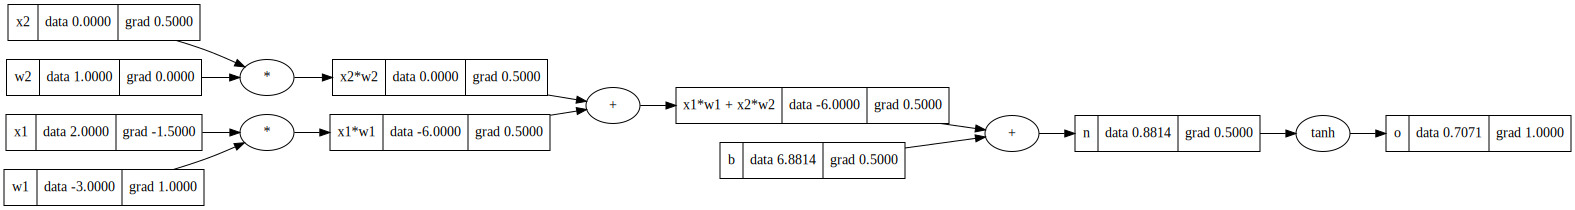

In [ ]:
# visualize the gradients and forward
o.backward()
draw_dot(o)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o1 = 2*n; o1.label = 'o1'
o2 = o1.exp(); o2.label = 'o2'
o = (o2-1) / (o2+1); o.label = 'o'

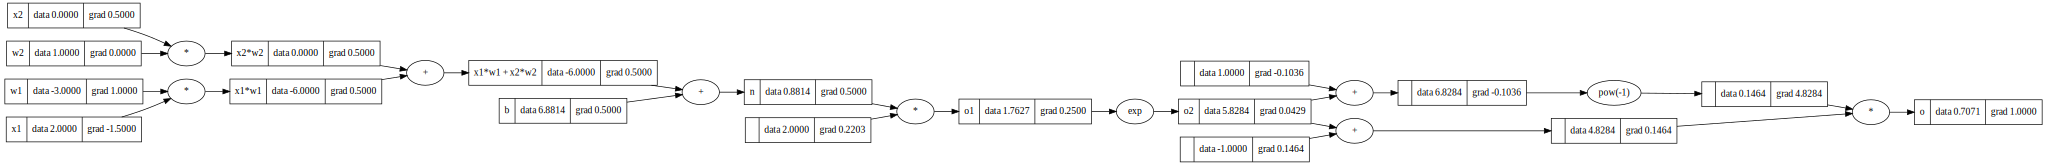

In [ ]:
# visualize the gradients and forward
o.backward()
draw_dot(o)

In [ ]:
import random
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
# define a mlp and train a model
mlp = MLP(3, [4, 4, 1])

In [ ]:
for e in range(10):
  params = mlp.parameters()

  pred = [mlp(x) for x in xs]
  loss = sum([(y_pred - y)**2 for y_pred, y in zip(pred, ys)])
  for p_ in params:
    p_.grad = 0

  loss.backward()

  for p_ in params:
    p_.data += -0.05 * p_.grad

  print(loss)


Value(data=2.558465767321507)
Value(data=0.8480369037127282)
Value(data=0.3198868148540581)
Value(data=0.19050247729033687)
Value(data=0.1393644749685043)
Value(data=0.10922863645469823)
Value(data=0.08948445588867643)
Value(data=0.07559980075679931)
Value(data=0.0653291385870524)
Value(data=0.05743817535413531)


In [ ]:
print([mlp(x) for x in xs])

[Value(data=0.9098741091445225), Value(data=-0.9346934057706205), Value(data=-0.8588441359636376), Value(data=0.8625896807620549)]
